In [93]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import cv2, os, math, time
from datetime import timedelta
from sklearn.utils import shuffle

In [94]:
tf.__version__

'1.6.0'

In [95]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

### Configuration

In [96]:
###Configuration
"""
Data Configurations/Paths
"""
img_dir="../../original_images/SD"

##
# Convolutional Layer 1.
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 32         # There are 32 of these filters.

# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 64         # There are 64 of these filters.

# Convolutional Layer 4.
filter_size4 = 2          # Convolution filters are 2 x 2 pixels.
num_filters4 = 128         # There are 128 of these filters.

# Fully-connected layer.
fc_size = 2000             # Number of neurons in fully-connected layer.

### Load Data

In [97]:
def change_label_dimensions(labels):
    label_temp = np.zeros((len(labels), 2))
    
    for idx in range(0, len(labels)):
        if labels[idx] == 1:
            label_temp[idx][1] = 1
        else:
            label_temp[idx][0] = 1
    
    return label_temp

def load_data(img_dir):
        list_of_imgs = []
        list_of_labels = []
        for img in os.listdir(img_dir):
            img_path = os.path.join(img_dir, img)
            for img_label in os.listdir(img_path):
                img_data = os.path.join(img_path, img_label)
                if img_label == "img":
#                     print(img_data + "/img.png")
                    list_of_imgs.append(img_data + "/img.png")
                else:
                        list_of_labels.append([os.path.join(img_data, label) for label in os.listdir(img_data)])

        data_imgs = np.array(list_of_imgs)
        data_labels = np.array(list_of_labels)

        return data_imgs, data_labels


# def load_data(img_dir, label):
#         list_of_imgs = []
#         list_of_labels = []
#         for img in os.listdir(img_dir):
#                 img = os.path.join(img_dir, img)
# #                 print(img)
#                 if not img.endswith(".png"):
#                         continue

#                 list_of_imgs.append(img)
#                 list_of_labels.append(label)
#         data_labels = np.asarray(list_of_labels, dtype=np.int32)
#         data_imgs = np.array(list_of_imgs)
# #         data_labels = np.array(list_of_labels)
#         return data_imgs, data_labels
    
def get_batch_images(data, label):
        list_of_imgs = []
        list_of_labels = []
        for img, lbl in zip(data, label):
#             print(img, lbl)
            orig_img = cv2.imread(img)
            #only first image as a label
            orig_lbl = cv2.imread(lbl[0])
            if orig_img is None or orig_lbl is None:
                    print ("Unable to read image{} or {}".format(img, lbl))
                    continue
            
            flattened_img = orig_img.flatten()
            flattened_lbl = orig_lbl.flatten()
            
#             flattened_a = tf.cast(flattened_a, tf.float32)
                
#             print(type(flattened_a.shape)) 
#             print(type(np.asarray(flattened_a, dtype=np.float32)))
            
            list_of_imgs.append(np.asarray(flattened_img, dtype=np.float32))
            list_of_labels.append(np.asarray(flattened_lbl, dtype=np.float32))

        data_labels = np.array(list_of_labels)
        data_imgs = np.array(list_of_imgs)
        
#         print(data_imgs)
#         print(data_labels)
        
        return data_imgs, data_labels

# train_imgs, train_labels = load_data(img_dir)
# train_imgs1, train_labels1 = get_batch_images(train_imgs[:5], train_labels[:5])

# print(train_imgs1)
# print(train_labels1)

### Next Batch Own Implementation

In [98]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

### Data Dimensions

In [99]:
# We know that images are 60 pixels in each dimension.
# img_size = 8 * 4

# Images are stored in one-dimensional arrays of this length.
img_size_flat = 60 * 60

# Number of colour channels for the images: 3 channel for RGB.
num_channels = 3

# Tuple with height and width of images used to reshape arrays.
img_shape = (60, 60, num_channels)


# Number of classes, one class for same or different image
num_classes = 20*20

### Image Plot Functions

In [100]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
        
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(cv2.imread(images[i]).flatten().reshape((8,4, 3)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
    
def generate_size_graph(fig_no, training_size, accuracy, loss, patch_only,patch_conv, start_size, end_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(training_size,accuracy)
    plt.plot(training_size,loss)
    plt.plot(training_size, patch_only)
    plt.plot(training_size, patch_conv)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Training Size vs Accuracy')
    plt.grid(True)
    plt.legend(['SD Original Accuracy','SR Accuracy', 'SD Patch Accuracy', 'SD Patch Conv'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(path + '/batch_graphs/' +  str(start_size) + '_' + str(end_size) + '.jpg') 
        
def generate_graph(fig_no, epochs, train, val, label, train_title, val_title, train_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(epochs,train)
    plt.plot(epochs,val)
    plt.xlabel('num of Epochs')
    plt.ylabel(label)
    plt.title(train_title + ' vs ' + val_title + '( Samples:' + str(train_size) + ')')
    plt.grid(True)
    plt.legend(['train','val'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(results_path + '/batch_graphs/' +  label + '_' + str(train_size) + '.jpg')     

### Plot Few Images

In [ ]:
# Get the first images from the train-set.
images = train_data[0:9]
# Get the true classes for those images.
cls_true = train_labels[0:9]
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Helper Functions for TF Graph Initialization

In [101]:
def new_weights(shape, layer_name):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape), name=layer_name+'_W')
#     return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_bias(length, layer_name):
    return tf.Variable(tf.constant(0.05, shape=[length]), name=layer_name+'_b')

### Helper Functions for Network

In [102]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   name_scope,
                   layer_name='',
                   use_pooling=True):

    with tf.name_scope(name_scope):
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        weights = new_weights(shape, layer_name)
        biases = new_bias(num_filters, layer_name)
    #     layer = tf.nn.conv2d(input=input,
    #                      filter=weights,
    #                      strides=[1, 1, 1, 1],
    #                      padding='SAME')
    #     layer += biases

        layer = tf.add(tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1], padding='SAME'), biases, name=layer_name)

        if use_pooling:
            layer = tf.nn.max_pool(value=layer,
                                   ksize=[1, 3, 3, 1],
                                   strides=[1, 2, 2, 1],
                                   padding='SAME', name=layer_name+'_max')
        layer = tf.nn.relu(layer, name=layer_name+'_activation')

    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

def new_fc_layer(input,
                num_inputs,
                num_outputs,
                name_scope,
                layer_name='',
                use_relu=True):
    
    with tf.name_scope(name_scope):
        weights = new_weights([num_inputs, num_outputs], layer_name)
        biases = new_bias(num_outputs, layer_name)

        layer = tf.add(tf.matmul(input, weights),biases,name=layer_name)
    #     layer = tf.matmul(input, weights) + biases

        if use_relu:
            layer = tf.nn.relu(layer, layer_name+'_activation')
    
    return layer

In [ ]:
img_size_flat

In [103]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat*num_channels], name='x')
x_image = tf.reshape(x, [-1, 60, 60, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes * num_channels], name='y_true')
# y_true_cls = tf.argmax(y_true, axis=1)
y_true_cls = tf.placeholder(tf.float32, shape=[None, num_classes * num_channels], name='y_true_cls')
x_image.shape, y_true

(TensorShape([Dimension(None), Dimension(60), Dimension(60), Dimension(3)]),
 <tf.Tensor 'y_true_3:0' shape=(?, 1200) dtype=float32>)

### Convolution Layers

In [104]:
layer1_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                             name_scope = 'cv',
                                             layer_name='conv1',
                                            use_pooling=True)

layer2_conv2, weights_conv2 =  new_conv_layer(input=layer1_conv1,
                                           num_input_channels=num_filters1,
                                           filter_size=filter_size2,
                                           num_filters=num_filters2,
                                             name_scope = 'cv',
                                             layer_name='conv2',
                                           use_pooling=True)

layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
                                           num_input_channels=num_filters2,
                                           filter_size=filter_size3,
                                           num_filters=num_filters3,
                                             name_scope = 'cv',
                                             layer_name='conv3',
                                           use_pooling=True)

layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
                                           num_input_channels=num_filters3,
                                           filter_size=filter_size4,
                                           num_filters=num_filters4,
                                             name_scope = 'cv',
                                             layer_name='conv4',
                                           use_pooling=True)

In [105]:
layer_flat, num_features = flatten_layer(layer4_conv4)

### Fully Connected Layers

In [106]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         name_scope = 'fc',
                         layer_name = 'fc1',
                         use_relu=True)


layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         name_scope = 'fc',
                         layer_name = 'fc2',
                         use_relu=False)

layer_fc3 = new_fc_layer(input=layer_fc2,
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         name_scope = 'fc',
                         layer_name = 'fc3',
                         use_relu=False)

layer_fc4 = new_fc_layer(input=layer_fc3,
                         num_inputs=fc_size,
                         num_outputs=num_classes * num_channels,
                         name_scope = 'fc',
                         layer_name = 'fc4',
                         use_relu=False)

# drop_out = tf.nn.dropout(layer_fc4, 0.5)

##Normalize the numbers(apply softmax!)
y_pred_cls = layer_fc4
y_pred = layer_fc4
# y_pred = tf.nn.softmax(drop_out)
# y_pred_cls = tf.argmax(y_pred, axis=1)

In [ ]:
layer_fc1

In [ ]:
y_pred

### Cost Function

In [107]:
# cost = tf.reduce_mean(-tf.reduce_sum(y_pred_cls * tf.log(y_true), reduction_indices=[1]))
cost = tf.reduce_mean(tf.square(y_true - y_pred_cls))
# cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred,
#                                                         labels=y_true)
# cost = tf.reduce_mean(cross_entropy)

### Optimization Method

In [108]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## some more performance measures
correct_prediction = tf.equal(y_pred_cls, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Run Tensorflow on Defined Graph

In [111]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_data, train_labels = load_data(img_dir)
train_batch_size = 64

def optimize(num_iterations, save_model=True,save_name=base_model,restore_model=False,restore_name=None):
    total_iterations = 0
    done_train_imgs = 0
    start_time = time.time()
    start_batch=0
    end_batch = train_batch_size
    plot_accuracy=[]
    plot_training_size=[]
    
    #to save the model
    saver = tf.train.Saver()

    if restore_model==True:
        if restore_name==None:
            print("No model file specified")
            return
        else:
            saver.restore(session,restore_name)
            
    
    for i in range(0, num_iterations):
        total_iterations = 0
        start_batch=0
        end_batch = train_batch_size
#         train_data, train_labels = load_data(img_dir)
        while True:
            train = train_data[start_batch:end_batch]
            labels = train_labels[start_batch:end_batch]
            train, labels = get_batch_images(train, labels)
            if not len(train) and not len(labels):
                print("All images have been processed.")
                break;

            x_batch, y_true_batch = next_batch(train_batch_size, train, labels)
    #         x_batch, y_true_batch = train_data[done_train_images:done_train_imgs+train_batch_size]
            feed_dict_train = {x: x_batch,
                       y_true: y_true_batch}
            
            session.run(optimizer, feed_dict=feed_dict_train)

    #         if total_iterations%1000==0:    
            acc,co = session.run([accuracy, cost], feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Loss: {2:>.4f}"
            print(msg.format(total_iterations + 1, acc, co))
            
            plot_accuracy.append(acc)
            plot_training_size.append((total_iterations + 1) * 64)

                # Update the total number of iterations performed.
    #         done_train_imgs+=train_batch_size
            start_batch += train_batch_size
            end_batch += train_batch_size
            total_iterations +=1

        if save_model==True:
            if save_name==None:
                print("No model specified, model not being saved")
                return
            else:
                save_path = saver.save(session, save_name)
                print("Model saved in file: %s" % save_name)
        
#         total_iterations += num_iterations

    # Ending time.
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))  
    print(plot_accuracy)
    print(plot_training_size)

### Performance/Optimization

In [158]:
base_model = 'SD/sd_01_.ckpt'
save_model = True
save_name = base_model
restore_model=False
restore_name=None

optimize(num_iterations=10, save_model=True,save_name=base_model,restore_model=False,restore_name=base_model)

Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 19872.1094
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 17603.2695
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 15479.3115
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 13197.9932
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 11338.6182
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 10457.6719
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 10236.4473
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 9455.6299
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 8681.0791
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 8190.6719
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 8048.7217
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 8117.8433
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 8256.5234
Optimization Itera

Optimization Iteration:     47, Training Accuracy:   0.0%, Loss: 7476.6567
Optimization Iteration:     48, Training Accuracy:   0.0%, Loss: 7480.4683
Optimization Iteration:     49, Training Accuracy:   0.0%, Loss: 7485.8501
Optimization Iteration:     50, Training Accuracy:   0.0%, Loss: 7497.4814
Optimization Iteration:     51, Training Accuracy:   0.0%, Loss: 7490.0850
Optimization Iteration:     52, Training Accuracy:   0.0%, Loss: 7495.8535
Optimization Iteration:     53, Training Accuracy:   0.0%, Loss: 7483.4766
Optimization Iteration:     54, Training Accuracy:   0.0%, Loss: 7486.4067
Optimization Iteration:     55, Training Accuracy:   0.0%, Loss: 7482.1616
Optimization Iteration:     56, Training Accuracy:   0.0%, Loss: 7475.3335
Optimization Iteration:     57, Training Accuracy:   0.0%, Loss: 7484.2515
Optimization Iteration:     58, Training Accuracy:   0.0%, Loss: 7487.8560
Optimization Iteration:     59, Training Accuracy:   0.0%, Loss: 7479.3491
Optimization Iteration:  

Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 7468.8408
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 7462.5684
Optimization Iteration:     31, Training Accuracy:   0.0%, Loss: 7465.3999
Optimization Iteration:     32, Training Accuracy:   0.0%, Loss: 7463.2715
Optimization Iteration:     33, Training Accuracy:   0.0%, Loss: 7472.1099
Optimization Iteration:     34, Training Accuracy:   0.0%, Loss: 7456.5850
Optimization Iteration:     35, Training Accuracy:   0.0%, Loss: 7473.5298
Optimization Iteration:     36, Training Accuracy:   0.0%, Loss: 7462.4360
Optimization Iteration:     37, Training Accuracy:   0.0%, Loss: 7458.8174
Optimization Iteration:     38, Training Accuracy:   0.0%, Loss: 7463.6567
Optimization Iteration:     39, Training Accuracy:   0.0%, Loss: 7478.8467
Optimization Iteration:     40, Training Accuracy:   0.0%, Loss: 7456.8765
Optimization Iteration:     41, Training Accuracy:   0.0%, Loss: 7454.7285
Optimization Iteration:  

Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 7461.5166
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 7458.3223
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 7457.6733
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 7459.8184
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 7457.6157
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 7455.0342
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 7463.7368
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 7462.2476
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 7461.0469
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 7439.5752
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 7447.9019
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 7451.9019
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 7454.7876
Optimization Iteration:  

Optimization Iteration:     57, Training Accuracy:   0.0%, Loss: 7460.4233
Optimization Iteration:     58, Training Accuracy:   0.0%, Loss: 7450.9482
Optimization Iteration:     59, Training Accuracy:   0.0%, Loss: 7444.0552
Optimization Iteration:     60, Training Accuracy:   0.0%, Loss: 7454.9502
Optimization Iteration:     61, Training Accuracy:   0.0%, Loss: 7451.6968
Optimization Iteration:     62, Training Accuracy:   0.0%, Loss: 7454.0332
Optimization Iteration:     63, Training Accuracy:   0.0%, Loss: 7418.5981
All images have been processed.
Model saved in file: SD/sd_01_.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 7454.8232
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 7451.6401
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 7447.0098
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 7446.6831
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 7449.4136
Optimization Iteration:      6, 

Optimization Iteration:     39, Training Accuracy:   0.0%, Loss: 7449.0918
Optimization Iteration:     40, Training Accuracy:   0.0%, Loss: 7427.8867
Optimization Iteration:     41, Training Accuracy:   0.0%, Loss: 7426.0757
Optimization Iteration:     42, Training Accuracy:   0.0%, Loss: 7446.7939
Optimization Iteration:     43, Training Accuracy:   0.0%, Loss: 7430.1782
Optimization Iteration:     44, Training Accuracy:   0.0%, Loss: 7442.2690
Optimization Iteration:     45, Training Accuracy:   0.0%, Loss: 7435.9067
Optimization Iteration:     46, Training Accuracy:   0.0%, Loss: 7441.7393
Optimization Iteration:     47, Training Accuracy:   0.0%, Loss: 7431.7227
Optimization Iteration:     48, Training Accuracy:   0.0%, Loss: 7434.2769
Optimization Iteration:     49, Training Accuracy:   0.0%, Loss: 7437.9868
Optimization Iteration:     50, Training Accuracy:   0.0%, Loss: 7442.1592
Optimization Iteration:     51, Training Accuracy:   0.0%, Loss: 7440.2383
Optimization Iteration:  

In [159]:
def restore_see_layer(ix, model_name=None, var_name=None):
    with tf.Session('', tf.Graph()) as s:
        with s.graph.as_default():
            if ((model_name != None) and var_name != None):
                saver = tf.train.import_meta_graph(model_name+".meta")
                saver.restore(s, model_name)
                fd = {'x_3:0':ix}
                var_name=var_name+":0"
                
                
#                 for i in s.graph.get_operations():
#                     print(i.name)
                    
#                 result = 0
                result = s.run(var_name, feed_dict=fd)
    return result

In [160]:
train_data, train_labels = load_data(img_dir)
train = train_data[0:64]
labels = train_labels[0:64]
train, labels = get_batch_images(train, labels)



In [91]:
train[0:1, :].shape
# np.expand_dims(train[0], axis=0).shape

(1, 10800)

In [161]:
img_x = train[0:1, :]#np.expand_dims(train[0], axis=0).shape
lbl_x = labels[0:1, :]
output_cl1 = restore_see_layer(ix=img_x,model_name=base_model,var_name='fc_7/fc4')
print(output_cl1.shape)

INFO:tensorflow:Restoring parameters from SD/sd_01_.ckpt
(1, 1200)


In [156]:
def see_output(iNp,depth_filter_to_see=0,cmap="gray",figsize=(4,4)):
    img_x = iNp[0,:,:,depth_filter_to_see]
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_x)
    plt.show()

In [154]:
lbl_x.shape

(1, 1200)

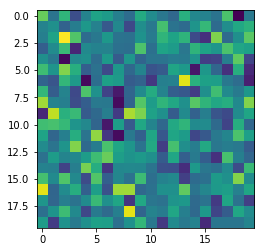

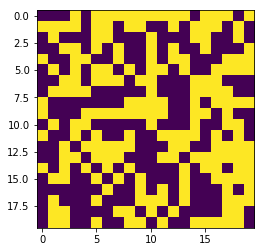

In [163]:
visual_image = np.reshape(output_cl1, (1, 20, 20, 3))
visual_label = np.reshape(lbl_x, (1, 20, 20, 3))

see_output(visual_image,1)
see_output(visual_label, 1)

In [ ]:
accuracy_sr_plot = [0.5, 0.75, 0.78125, 0.8125, 0.8125, 0.8125, 0.8125, 0.828125, 0.875, 0.90625, 0.78125, 0.90625, 0.78125, 0.921875, 0.828125, 0.921875]
accuracy_sd_plot = [0.421875, 0.484375, 0.484375, 0.453125, 0.578125, 0.515625, 0.5625, 0.5625, 0.5, 0.5625, 0.671875, 0.59375, 0.421875, 0.5625, 0.484375, 0.515625]
accuracy_sd_patchonly_plot = [0.578125, 0.890625, 0.8125, 0.890625, 0.890625, 0.8125, 0.796875, 0.9375, 0.90625, 0.890625, 0.90625, 0.84375, 0.859375, 0.828125, 0.9375, 0.890625]
accuracy_sd_conv_plot = [0.609375, 0.671875, 0.828125, 0.84375, 0.78125, 0.8125, 0.859375, 0.828125, 0.84375, 0.890625, 0.953125, 0.90625, 0.921875, 0.84375, 0.921875, 0.859375]
training_size_sd_plot = [64, 64064, 128064, 192064, 256064, 320064, 384064, 448064, 512064, 576064, 640064, 704064, 768064, 832064, 896064, 960064]

In [ ]:
# fig_no, training_size, accuracy, loss, start_size, end_size

generate_size_graph(1, training_size_sd_plot, accuracy_sd_plot, accuracy_sr_plot,accuracy_sd_patchonly_plot,accuracy_sd_conv_plot,  64, 960064)

### Plot Error

In [ ]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Print Accuracy

In [ ]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [ ]:
train_data[:64]

In [ ]:
x_batch, y_true_batch = data.test.next_batch(64)
x_batch

In [ ]:
type(data.train.labels)